##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tune Gemma models in Keras using LoRA

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemma/docs/lora_tuning"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/335"><img src="https://ai.google.dev/images/cloud-icon.svg" width="40" />Open in Vertex AI</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

Gemma is a family of lightweight, state-of-the art open models built from the same research and technology used to create the Gemini models.

Large Language Models (LLMs) like Gemma have been shown to be effective at a variety of NLP tasks. An LLM is first pre-trained on a large corpus of text in a self-supervised fashion. Pre-training helps LLMs learn general-purpose knowledge, such as statistical relationships between words. An LLM can then be fine-tuned with domain-specific data to perform downstream tasks (such as sentiment analysis).

LLMs are extremely large in size (parameters in the order of millions). Full fine-tuning (which updates all the parameters in the model) is not required for most applications because typical fine-tuning datasets are relatively much smaller than the pre-training datasets.

[Low Rank Adaptation (LoRA)](https://arxiv.org/abs/2106.09685){:.external} is a fine-tuning technique which greatly reduces the number of trainable parameters for downstream tasks by freezing the weights of the model and inserting a smaller number of new weights into the model. This makes training with LoRA much faster and more memory-efficient, and produces smaller model weights (a few hundred MBs), all while maintaining the quality of the model outputs.

This tutorial walks you through using KerasNLP to perform LoRA fine-tuning on a Gemma 2B model using the [Databricks Dolly 15k dataset](https://www.kaggle.com/datasets/databricks/databricks-dolly-15k){:.external}. This dataset contains 15,000 high-quality human-generated prompt / response pairs specifically designed for fine-tuning LLMs.

## Setup

### Get access to Gemma

To complete this tutorial, you will first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

Gemma models are hosted by Kaggle. To use Gemma, request access on Kaggle:

- Sign in or register at [kaggle.com](https://www.kaggle.com)
- Open the [Gemma model card](https://www.kaggle.com/models/google/gemma) and select _"Request Access"_
- Complete the consent form and accept the terms and conditions


### Install dependencies

Install Keras, KerasNLP, and other dependencies.

In [ ]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

### Select a backend

Keras is a high-level, multi-framework deep learning API designed for simplicity and ease of use. Using Keras 3, you can run workflows on one of three backends: TensorFlow, JAX, or PyTorch.

For this tutorial, configure the backend for JAX.

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

### Import packages

Import Keras and KerasNLP.

In [ ]:
import keras
import keras_nlp

## Load Dataset

Preprocess the data. This tutorial uses a subset of 1000 training examples to execute the notebook faster. Consider using more training data for higher quality fine-tuning.

In [ ]:
import json
data = []
with open('/kaggle/input/databricks-dolly-15k/databricks-dolly-15k.jsonl') as file:
    for line in file:
        features = json.loads(line)
        # Filter out examples with context, to keep it simple.
        if features["context"]:
            continue
        # Format the entire example as a single string.
        template = "Instruction:\n{instruction}\n\nResponse:\n{response}"
        data.append(template.format(**features))

# Only use 1000 training examples, to keep it fast.
data = data[:1000]

In [ ]:
data[:2]

## Load Model

KerasNLP provides implementations of many popular [model architectures](https://keras.io/api/keras_nlp/models/){:.external}. In this tutorial, you'll create a model using `GemmaCausalLM`, an end-to-end Gemma model for causal language modeling. A causal language model predicts the next token based on previous tokens.

Create the model using the `from_preset` method:

In [ ]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

The `from_preset` method instantiates the model from a preset architecture and weights. In the code above, the string "gemma_2b_en" specifies the preset architecture — a Gemma model with 2 billion parameters.

NOTE: A Gemma model with 7
billion parameters is also available. To run the larger model in Colab, you need access to the premium GPUs available in paid plans. Alternatively, you can perform [distributed tuning on a Gemma 7B model](https://ai.google.dev/gemma/docs/distributed_tuning) on Kaggle or Google Cloud.

## Inference before fine tuning

In this section, you will query the model with various prompts to see how it responds.


### Europe Trip Prompt

Query the model for suggestions on what to do on a trip to Europe.

In [ ]:
prompt = template.format(
    instruction="What should I do on a trip to Europe?",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

The model just responds with a recommendation to take a trip to Europe.

### ELI5 Photosynthesis Prompt

Prompt the model to explain photosynthesis in terms simple enough for a 5 year old child to understand.


In [ ]:
prompt = template.format(
    instruction="Explain the process of photosynthesis in a way that a child could understand.",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

The responses contains words that might not be easy to understand for a child such as chlorophyll, glucose, etc.

## LoRA Fine-tuning

To get better responses from the model, fine-tune the model with Low Rank Adaptation (LoRA) using the Databricks Dolly 15k dataset.

The LoRA rank determines the dimensionality of the trainable matrices that are added to the original weights of the LLM. It controls the expressiveness and precision of the fine-tuning adjustments.

A higher rank means more detailed changes are possible, but also means more trainable parameters. A lower rank means less computational overhead, but potentially less precise adaptation.

This tutorial uses a LoRA rank of 4. In practice, begin with a relatively small rank (such as 4, 8, 16). This is computationally efficient for experimentation. Train your model with this rank and evaluate the performance improvement on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

set the LoRA rank to 4: 设置 LoRA 的“秩”（rank）为 4。在 LoRA 中，我们注入的低秩矩阵的大小由秩来决定。一个较低的秩（例如 4, 8, 16）意味着更少的参数和更快的训练，但也可能限制模型的表达能力。选择合适的秩是微调的关键之一。

Enable LoRA for the model: 启用 LoRA (Low-Rank Adaptation) 技术。LoRA 是一种高效的微调方法，它通过在预训练模型的每一层（或特定层）中注入少量可训练的低秩矩阵来更新模型，而无需修改和重新训练整个庞大的模型权重。这大大减少了可训练参数的数量，从而降低了计算成本和内存需求，同时通常能保持与全模型微调相似的性能。

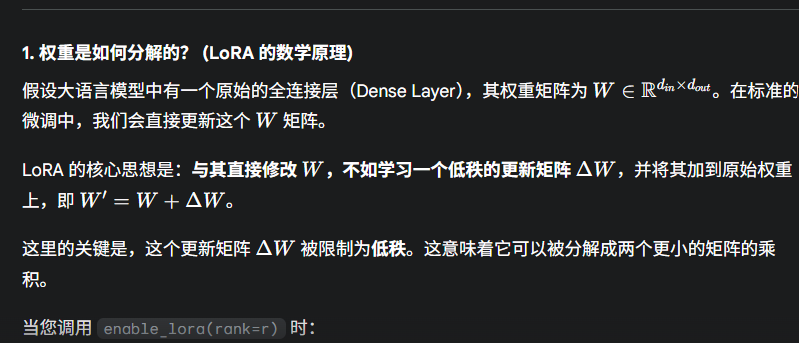

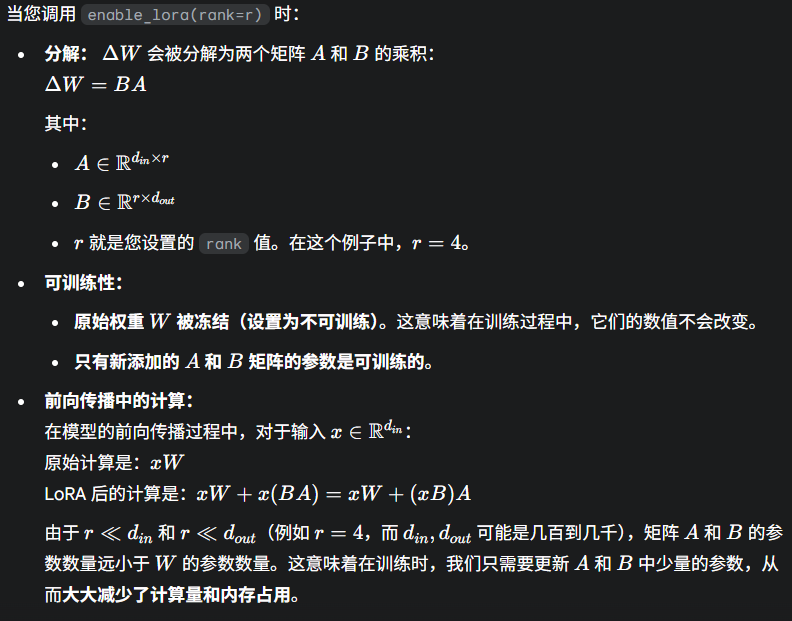

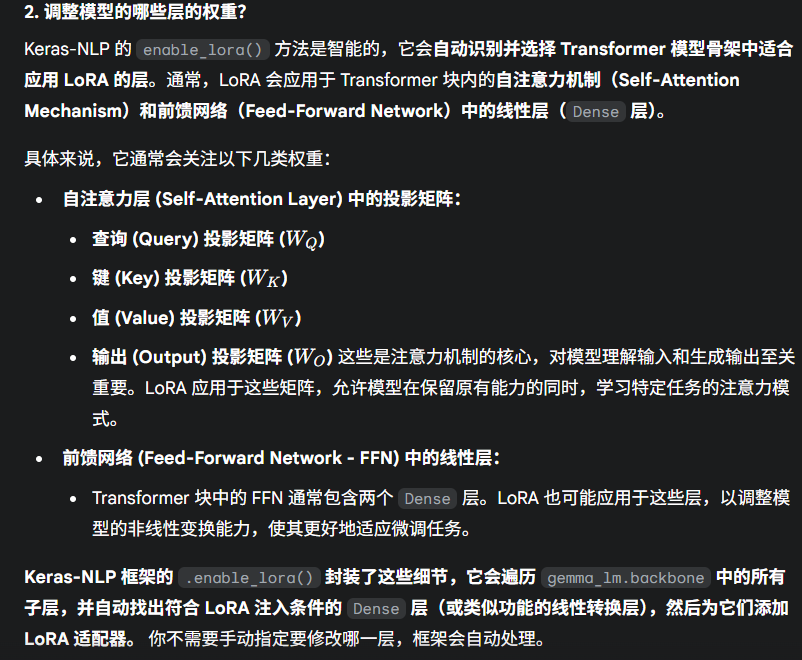

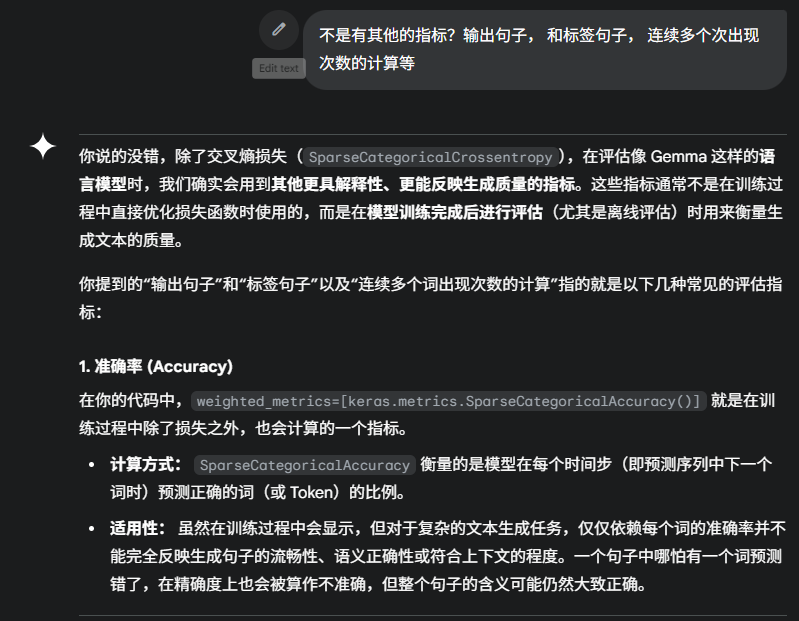

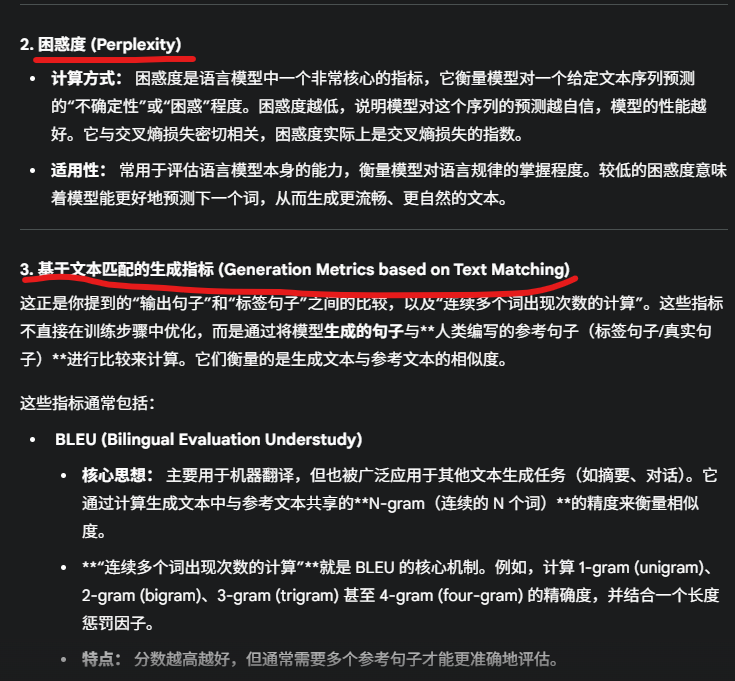

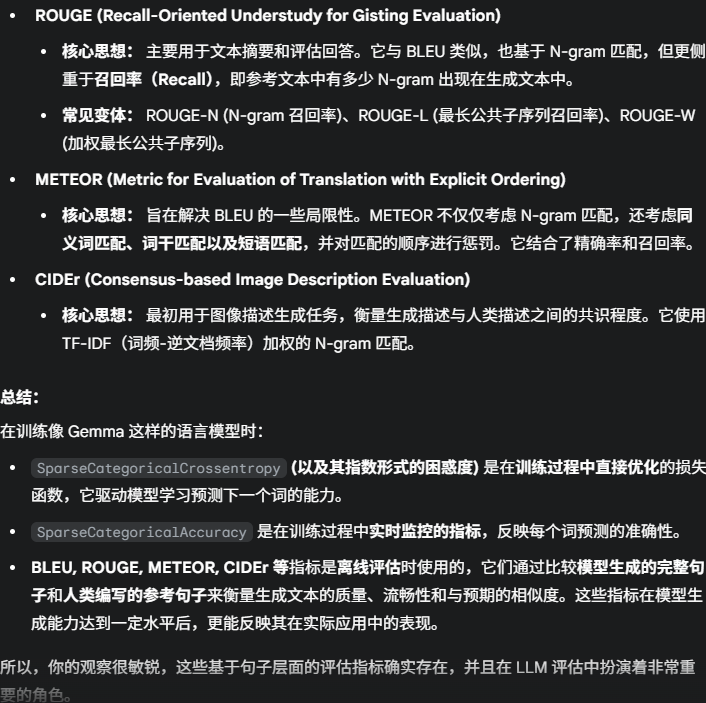

Note that enabling LoRA reduces the number of trainable parameters significantly (from 2.5 billion to 1.3 million).

In [ ]:
data2 = data[:10]

In [ ]:
# Limit the input sequence length to 512 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 512
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(data2, epochs=1, batch_size=1)

In [ ]:
del gemma_lm

## Inference after fine-tuning
After fine-tuning, responses follow the instruction provided in the prompt.

### Europe Trip Prompt


In [ ]:
prompt = template.format(
    instruction="What should I do on a trip to Europe?",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

The model now recommends places to visit in Europe.

### ELI5 Photosynthesis Prompt


In [ ]:
prompt = template.format(
    instruction="Explain the process of photosynthesis in a way that a child could understand.",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

The model now explains photosynthesis in simpler terms.

Note that for demonstration purposes, this tutorial fine-tunes the model on a small subset of the dataset for just one epoch and with a low LoRA rank value. To get better responses from the fine-tuned model, you can experiment with:

1. Increasing the size of the fine-tuning dataset
2. Training for more steps (epochs)
3. Setting a higher LoRA rank
4. Modifying the hyperparameter values such as `learning_rate` and `weight_decay`.


## Summary and next steps

This tutorial covered LoRA fine-tuning on a Gemma model using KerasNLP. Check out the following docs next:

* Learn how to [generate text with a Gemma model](https://ai.google.dev/gemma/docs/get_started).
* Learn how to perform [distributed fine-tuning and inference on a Gemma model](https://ai.google.dev/gemma/docs/distributed_tuning).
* Learn how to [use Gemma open models with Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/open-models/use-gemma).
* Learn how to [fine-tune Gemma using KerasNLP and deploy to Vertex AI](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_gemma_kerasnlp_to_vertexai.ipynb).
